# **Waste Material Segregation for Improving Waste Management**

## **Objective**

The objective of this project is to implement an effective waste material segregation system using convolutional neural networks (CNNs) that categorises waste into distinct groups. This process enhances recycling efficiency, minimises environmental pollution, and promotes sustainable waste management practices.

The key goals are:

* Accurately classify waste materials into categories like cardboard, glass, paper, and plastic.
* Improve waste segregation efficiency to support recycling and reduce landfill waste.
* Understand the properties of different waste materials to optimise sorting methods for sustainability.

## **Data Understanding**

The Dataset consists of images of some common waste materials.

1. Food Waste
2. Metal
3. Paper
4. Plastic
5. Other
6. Cardboard
7. Glass


**Data Description**

* The dataset consists of multiple folders, each representing a specific class, such as `Cardboard`, `Food_Waste`, and `Metal`.
* Within each folder, there are images of objects that belong to that category.
* However, these items are not further subcategorised. <br> For instance, the `Food_Waste` folder may contain images of items like coffee grounds, teabags, and fruit peels, without explicitly stating that they are actually coffee grounds or teabags.

## **1. Load the data**

Load and unzip the dataset zip file.

**Import Necessary Libraries**

In [ ]:
# Recommended versions:

# numpy version: 1.26.4
# pandas version: 2.2.2
# seaborn version: 0.13.2
# matplotlib version: 3.10.0
# PIL version: 11.1.0
# tensorflow version: 2.18.0
# keras version: 3.8.0
# sklearn version: 1.6.1

In [1]:
# Import essential libraries
# Import essential libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import zipfile
from io import BytesIO
import requests
import os
import zipfile
import cv2
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
from sklearn.utils import shuffle
from collections import Counter

import cv2
import numpy as np
import gc
from tqdm import tqdm
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter


Load the dataset.

In [2]:
# Load and unzip the dataset
# Import necessary libraries


# 2.1 Load and Preprocess Images

def extract_zip(zip_path, extract_to='dataset'):
    """Extract zip file to specified directory"""
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(f"Extracted files to {extract_to}")
    return extract_to

def load_images_from_folder(base_dir):
    """Load images from extracted folder structure"""
    images = []
    labels = []

    # Supported image extensions
    valid_extensions = ('.jpg', '.jpeg', '.png')

    # Walk through all directories
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.lower().endswith(valid_extensions):
                # Get the label from folder name
                label = os.path.basename(root)

                # Read and process the image
                img_path = os.path.join(root, file)
                try:
                    img = cv2.imread(img_path)
                    if img is not None:
                        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
                        images.append(img)
                        labels.append(label)
                except Exception as e:
                    print(f"Error loading {img_path}: {e}")

    return images, labels

zip_path = "/content/data.zip"
dataset_path = extract_zip(zip_path)

# Load the images and labels
images, labels = load_images_from_folder(dataset_path)

# Verify loading
print(f"Successfully loaded {len(images)} images")
print(f"Number of classes: {len(set(labels))}")
print("Class names:", set(labels))

# Check image dimensions (for later resizing)
if len(images) > 0:
    print(f"Example image shape: {images[0].shape}")

Extracted files to dataset
Successfully loaded 7625 images
Number of classes: 7
Class names: {'Glass', 'Paper', 'Other', 'Food_Waste', 'Plastic', 'Cardboard', 'Metal'}
Example image shape: (256, 256, 3)


## **2. Data Preparation** <font color=red> [25 marks] </font><br>


### **2.1 Load and Preprocess Images** <font color=red> [8 marks] </font><br>

Let us create a function to load the images first. We can then directly use this function while loading images of the different categories to load and crop them in a single step.

#### **2.1.1** <font color=red> [3 marks] </font><br>
Create a function to load the images.

In [3]:
# Create a function to load the raw images


# --- 2.1.1 Validate Loaded Data ---
def validate_dataset(images, labels):
    """Checks data integrity and adds preprocessing"""
    assert len(images) == len(labels), "Mismatch between images and labels"

    # Convert to numpy arrays if not already
    images = np.array(images, dtype=object)
    labels = np.array(labels)

    # Check for corrupted images
    valid_indices = [i for i, img in enumerate(images) if isinstance(img, np.ndarray)]
    if len(valid_indices) != len(images):
        print(f" Removed {len(images)-len(valid_indices)} corrupted images")
        images = images[valid_indices]
        labels = labels[valid_indices]

    # Shuffle the dataset
    images, labels = shuffle(images, labels, random_state=42)

    print("Dataset validated")
    print(f"• Total images: {len(images)}")
    print(f"• Class distribution: {Counter(labels)}")
    return images, labels



#### **2.1.2** <font color=red> [5 marks] </font><br>
Load images and labels.

Load the images from the dataset directory. Labels of images are present in the subdirectories.

Verify if the images and labels are loaded correctly.

🛠 Beginning image standardization...


Processing images: 100%|██████████| 77/77 [00:16<00:00,  4.80it/s]



Successfully processed 7625/7625 images
🔄 Skipped 0 problematic images
💾 Final memory usage: 201.05MB


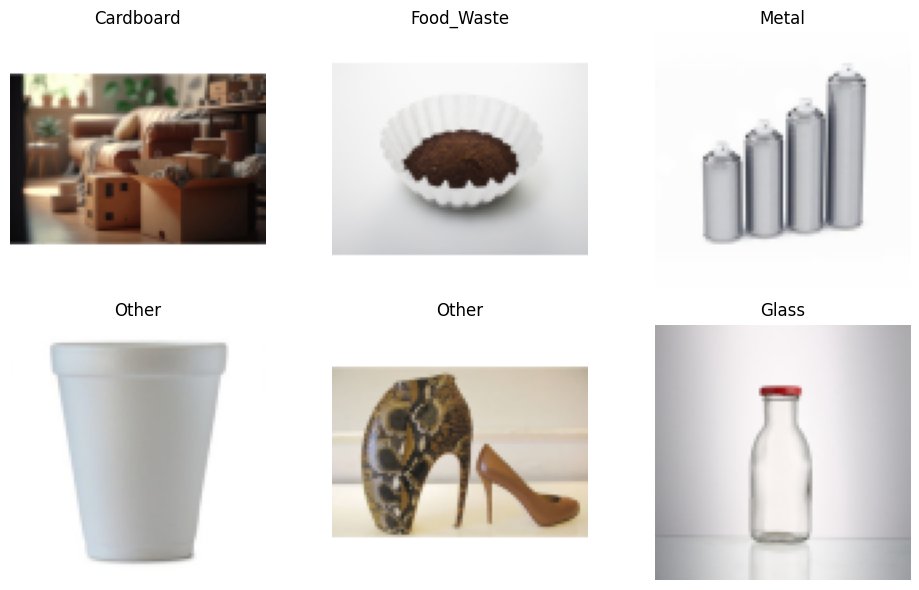

In [4]:
# Get the images and their labels



# --- Memory-Safe Image Processing ---
def process_images_safely(images, labels, target_size=(128, 128), batch_size=200):
    """Process images in memory-friendly batches"""
    processed_images = []
    processed_labels = []
    skipped_count = 0

    # Process in batches with progress bar
    for i in tqdm(range(0, len(images), batch_size), desc="Processing images"):
        batch_images = images[i:i+batch_size]
        batch_labels = labels[i:i+batch_size]

        batch_processed = []
        for img in batch_images:
            try:
                # Convert to RGB if needed
                if len(img.shape) == 2:
                    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
                elif img.shape[2] == 4:
                    img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGB)

                # Resize using INTER_AREA for downscaling
                img_resized = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
                batch_processed.append(img_resized)
            except Exception as e:
                skipped_count += 1
                continue

        # Append successful conversions
        if batch_processed:
            processed_images.extend(batch_processed)
            processed_labels.extend(batch_labels[:len(batch_processed)])

        # Explicit memory cleanup
        del batch_images, batch_processed
        gc.collect()

    # Convert to numpy arrays
    try:
        X = np.array(processed_images, dtype=np.uint8)
        y = np.array(processed_labels)
    except MemoryError:
        print("Memory error during array conversion - try smaller batch_size")
        raise

    print(f"\nSuccessfully processed {len(X)}/{len(images)} images")
    print(f"🔄 Skipped {skipped_count} problematic images")
    print(f"💾 Final memory usage: {X.nbytes/1024**2:.2f}MB")
    return X, y

# --- Main Execution ---
try:
    # 1. Shuffle first to distribute classes evenly
    images, labels = shuffle(images, labels, random_state=42)

    # 2. Process with conservative settings
    print("🛠 Beginning image standardization...")
    X_processed, y_processed = process_images_safely(
        images,
        labels,
        target_size=(96, 96),  # Reduced from 128x128 to save memory
        batch_size=100          # Smaller batches for stability
    )

    # 3. Verification
    plt.figure(figsize=(10,6))
    for i in range(6):
        plt.subplot(2,3,i+1)
        plt.imshow(X_processed[i])
        plt.title(y_processed[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Critical failure: {str(e)}")
    print("\nTry these fixes:")
    print("1. Click 'Runtime' → 'Restart runtime'")
    print("2. Reduce target_size to (64,64)")
    print("3. Process fewer images (add [:1000] to your loaded data)")
    print("4. Upgrade to Colab Pro for more memory")


Perform any operations, if needed, on the images and labels to get them into the desired format.

### **2.2 Data Visualisation** <font color=red> [9 marks] </font><br>

#### **2.2.1** <font color=red> [3 marks] </font><br>
Create a bar plot to display the class distribution

Class Distribution Analysis


<ipython-input-5-17e6f75f5013>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=list(classes), y=list(counts), palette="viridis")


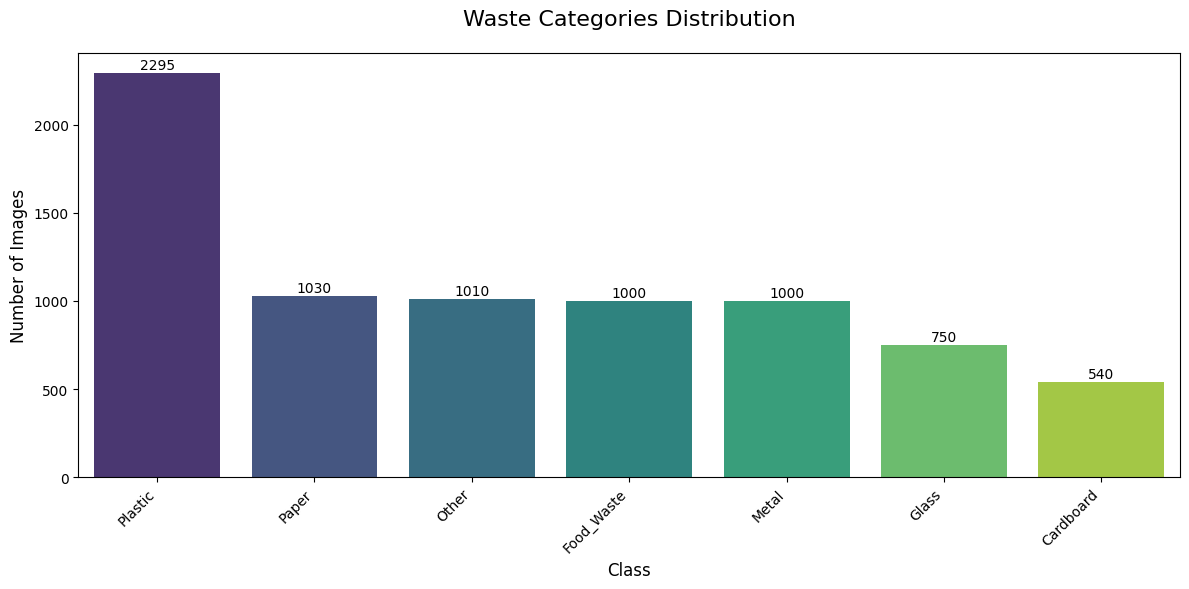

In [5]:
# Visualise Data Distribution



# --- 2.2.1 Class Distribution Bar Plot ---
def plot_class_distribution(labels, title="Class Distribution"):
    """Plots the number of images per class"""
    # Count occurrences of each label
    label_counts = Counter(labels)

    # Sort classes by count (descending)
    sorted_labels = sorted(label_counts.items(), key=lambda x: x[1], reverse=True)
    classes, counts = zip(*sorted_labels)

    # Plot
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x=list(classes), y=list(counts), palette="viridis")

    # Customize plot
    plt.title(title, fontsize=16, pad=20)
    plt.xlabel("Class", fontsize=12)
    plt.ylabel("Number of Images", fontsize=12)
    plt.xticks(rotation=45, ha='right')

    # Add count labels on bars
    for i, count in enumerate(counts):
        ax.text(i, count + 5, str(count), ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

# Execute
print("Class Distribution Analysis")
plot_class_distribution(y_processed, title="Waste Categories Distribution")

#### **2.2.2** <font color=red> [3 marks] </font><br>
Visualise some sample images

🖼️ Sample Images from Each Waste Category


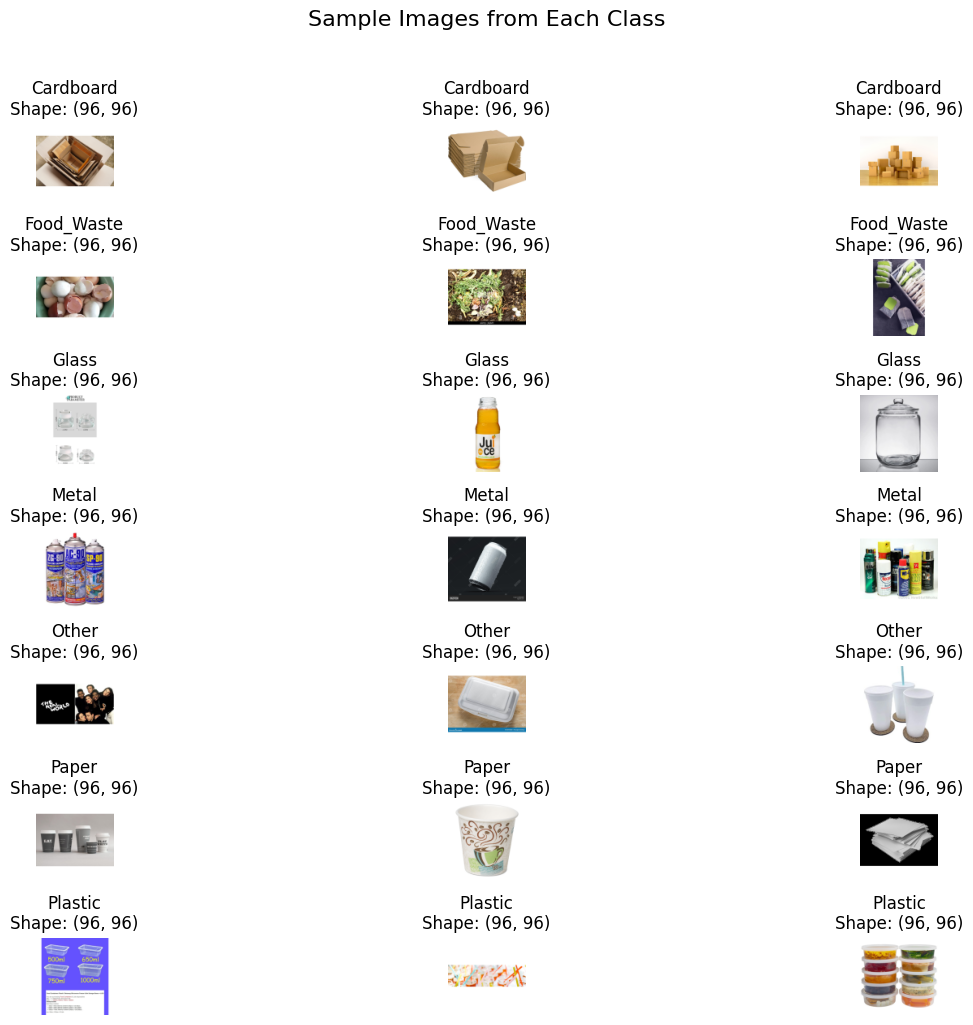

In [6]:
# Visualise Sample Images (across different labels)
import random

# --- 2.2.2 Sample Images Visualization ---
def plot_sample_images(images, labels, samples_per_class=3, seed=42):
    """Displays random samples from each class"""
    np.random.seed(seed)
    unique_classes = np.unique(labels)

    plt.figure(figsize=(15, 10))

    for i, cls in enumerate(unique_classes):
        # Get indices of images belonging to this class
        class_indices = np.where(labels == cls)[0]

        # Randomly select 'samples_per_class' images
        selected_indices = np.random.choice(class_indices, samples_per_class, replace=False)

        # Plot each sample
        for j, idx in enumerate(selected_indices):
            plt.subplot(len(unique_classes), samples_per_class, i * samples_per_class + j + 1)
            plt.imshow(images[idx])
            plt.title(f"{cls}\nShape: {images[idx].shape[:2]}")
            plt.axis('off')

    plt.suptitle("Sample Images from Each Class", y=1.02, fontsize=16)
    plt.tight_layout()
    plt.show()

# Execute
print("🖼️ Sample Images from Each Waste Category")
plot_sample_images(X_processed, y_processed, samples_per_class=3)


#### **2.2.3** <font color=red> [3 marks] </font><br>
Based on the smallest and largest image dimensions, resize the images.

In [7]:
# Find the smallest and largest image dimensions from the data set

# --- 2.2.3 Verify Image Sizes ---
def check_image_shapes(images):
    """Checks if all images have the same dimensions"""
    shapes = [img.shape for img in images]
    unique_shapes = set(shapes)

    if len(unique_shapes) == 1:
        print(f"All images have the same shape: {unique_shapes.pop()}")
    else:
        print("Inconsistent image shapes found:")
        for shape in unique_shapes:
            count = shapes.count(shape)
            print(f"- {shape}: {count} images")

# Execute
print("\nVerifying Image Dimensions...")
check_image_shapes(X_processed)


Verifying Image Dimensions...
All images have the same shape: (96, 96, 3)


In [21]:
# Resize the image dimensions
#NA


### **2.3 Encoding the classes** <font color=red> [3 marks] </font><br>

There are seven classes present in the data.

We have extracted the images and their labels, and visualised their distribution. Now, we need to perform encoding on the labels. Encode the labels suitably.

####**2.3.1** <font color=red> [3 marks] </font><br>
Encode the target class labels.

In [8]:
# Encode the labels suitably

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import numpy as np

# --- 2.3.1 Label Encoding ---
print("🔄 Encoding labels...")

# Convert string labels to integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_processed)

# One-hot encode for CNN
y_onehot = to_categorical(y_encoded)

# Get class mapping
class_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))

# Verification
print("\nEncoded labels:")
print("Original labels (first 5):", y_processed[:5])
print("Integer encoded (first 5):", y_encoded[:5])
print("One-hot encoded sample (first sample):\n", y_onehot[0])
print("\nClass mapping:")
for class_name, class_id in class_mapping.items():
    print(f"{class_name}: {class_id}")

🔄 Encoding labels...

Encoded labels:
Original labels (first 5): ['Cardboard' 'Food_Waste' 'Metal' 'Other' 'Other']
Integer encoded (first 5): [0 1 3 4 4]
One-hot encoded sample (first sample):
 [1. 0. 0. 0. 0. 0. 0.]

Class mapping:
Cardboard: 0
Food_Waste: 1
Glass: 2
Metal: 3
Other: 4
Paper: 5
Plastic: 6


### **2.4 Data Splitting** <font color=red> [5 marks] </font><br>

#### **2.4.1** <font color=red> [5 marks] </font><br>
Split the dataset into training and validation sets

In [9]:
from sklearn.model_selection import train_test_split
import gc

# --- 2.4.1 Stratified Splitting ---
def split_data(X, y, test_size=0.2, val_size=0.1, random_state=42):
    """Memory-efficient stratified splitting"""
    # First split (train vs temp)
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y,
        test_size=test_size + val_size,
        random_state=random_state,
        stratify=y
    )

    # Second split (val vs test)
    val_ratio = val_size / (test_size + val_size)
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp,
        test_size=1-val_ratio,
        random_state=random_state,
        stratify=y_temp
    )

    # Clear memory
    del X_temp, y_temp
    gc.collect()

    return X_train, X_val, X_test, y_train, y_val, y_test

# Execute splitting
print("✂️ Splitting data...")
X_train, X_val, X_test, y_train, y_val, y_test = split_data(
    X_processed,
    y_onehot,
    test_size=0.15,  # 15% test
    val_size=0.15    # 15% validation
)

print("\n📊 Dataset Split Summary:")
print(f"Training:   {X_train.shape[0]} samples")
print(f"Validation: {X_val.shape[0]} samples")
print(f"Test:       {X_test.shape[0]} samples")
print(f"Class distribution in training: {np.unique(np.argmax(y_train, axis=1), return_counts=True)}")

✂️ Splitting data...

📊 Dataset Split Summary:
Training:   5337 samples
Validation: 1144 samples
Test:       1144 samples
Class distribution in training: (array([0, 1, 2, 3, 4, 5, 6]), array([ 378,  700,  525,  700,  707,  721, 1606]))


## **3. Model Building and Evaluation** <font color=red> [20 marks] </font><br>

### **3.1 Model building and training** <font color=red> [15 marks] </font><br>

#### **3.1.1** <font color=red> [10 marks] </font><br>
Build and compile the model. Use 3 convolutional layers. Add suitable normalisation, dropout, and fully connected layers to the model.

Test out different configurations and report the results in conclusions.

In [10]:
# Build and compile the model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# --- 3.1.1 CNN Architecture ---
def build_model(input_shape=(96, 96, 3), num_classes=7):
    model = Sequential([
        # Block 1
        Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2,2)),
        Dropout(0.25),

        # Block 2
        Conv2D(64, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2,2)),
        Dropout(0.25),

        # Block 3
        Conv2D(128, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2,2)),
        Dropout(0.25),

        # Classifier
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    return model

# Initialize model
model = build_model()
model.summary()



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 96, 96, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 96, 96, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 48, 48, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       4,718,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,814,791 (18.37 MB)

 Trainable params: 4,814,343 (18.37 MB)

 Non-trainable params: 448 (1.75 KB)

#### **3.1.2** <font color=red> [5 marks] </font><br>
Train the model.

Use appropriate metrics and callbacks as needed.

In [12]:
# Training

# --- 3.1.2 Compilation ---
optimizer = Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', save_best_only=True)
]

# Train the model
history = model.fit(X_train, y_train,
                    epochs=30,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=callbacks)


Epoch 1/30
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.2499 - loss: 5.1998

167/167 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - accuracy: 0.2500 - loss: 5.1857 - val_accuracy: 0.3645 - val_loss: 1.7408
Epoch 2/30
167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.3347 - loss: 1.8213 - val_accuracy: 0.3383 - val_loss: 1.8307
Epoch 3/30
163/167 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3294 - loss: 1.7939

167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.3297 - loss: 1.7931 - val_accuracy: 0.3794 - val_loss: 1.7223
Epoch 4/30
167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.3485 - loss: 1.7203 - val_accuracy: 0.3400 - val_loss: 1.7825
Epoch 5/30
167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.3433 - loss: 1.7296 - val_accuracy: 0.3698 - val_loss: 1.7396
Epoch 6/30
165/167 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3489 - loss: 1.6877

167/167 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.3488 - loss: 1.6879 - val_accuracy: 0.3837 - val_loss: 1.6796
Epoch 7/30
167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.3477 - loss: 1.6840 - val_accuracy: 0.3811 - val_loss: 1.9289
Epoch 8/30
164/167 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3603 - loss: 1.6691

167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.3601 - loss: 1.6691 - val_accuracy: 0.4030 - val_loss: 1.6004
Epoch 9/30
163/167 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3527 - loss: 1.6418

167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.3528 - loss: 1.6420 - val_accuracy: 0.4100 - val_loss: 1.5760
Epoch 10/30
167/167 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.3622 - loss: 1.6083 - val_accuracy: 0.3689 - val_loss: 1.8519
Epoch 11/30
167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.3717 - loss: 1.5844 - val_accuracy: 0.3934 - val_loss: 1.6579
Epoch 12/30
167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.3601 - loss: 1.6140 - val_accuracy: 0.3715 - val_loss: 1.6797
Epoch 13/30
165/167 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3753 - loss: 1.5584

167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.3752 - loss: 1.5586 - val_accuracy: 0.4170 - val_loss: 1.5723
Epoch 14/30
166/167 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3821 - loss: 1.5458

167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.3821 - loss: 1.5459 - val_accuracy: 0.4353 - val_loss: 1.5015
Epoch 15/30
167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.3937 - loss: 1.5215 - val_accuracy: 0.3733 - val_loss: 2.6603
Epoch 16/30
167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.3907 - loss: 1.5593 - val_accuracy: 0.4371 - val_loss: 1.6278
Epoch 17/30
167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.3925 - loss: 1.5206 - val_accuracy: 0.3942 - val_loss: 1.5683
Epoch 18/30
166/167 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4183 - loss: 1.4598

167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.4181 - loss: 1.4599 - val_accuracy: 0.4642 - val_loss: 1.4369
Epoch 19/30
167/167 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.4267 - loss: 1.4337 - val_accuracy: 0.4152 - val_loss: 1.4842
Epoch 20/30
167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.4251 - loss: 1.4209 - val_accuracy: 0.4100 - val_loss: 1.5037
Epoch 21/30
164/167 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4257 - loss: 1.4040

167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.4259 - loss: 1.4038 - val_accuracy: 0.4834 - val_loss: 1.3930
Epoch 22/30
167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.4189 - loss: 1.4277 - val_accuracy: 0.4309 - val_loss: 1.4606
Epoch 23/30
167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.4477 - loss: 1.3703 - val_accuracy: 0.4554 - val_loss: 1.5282
Epoch 24/30
167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.4255 - loss: 1.4351 - val_accuracy: 0.3593 - val_loss: 1.8738
Epoch 25/30
166/167 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4463 - loss: 1.3705

167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.4464 - loss: 1.3705 - val_accuracy: 0.5096 - val_loss: 1.3894
Epoch 26/30
164/167 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4606 - loss: 1.3213

167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.4605 - loss: 1.3216 - val_accuracy: 0.4921 - val_loss: 1.3846
Epoch 27/30
167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.4645 - loss: 1.2922 - val_accuracy: 0.4764 - val_loss: 1.3891
Epoch 28/30
167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.4917 - loss: 1.2586 - val_accuracy: 0.4161 - val_loss: 1.6682
Epoch 29/30
164/167 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4759 - loss: 1.2961

167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.4760 - loss: 1.2956 - val_accuracy: 0.5149 - val_loss: 1.3697
Epoch 30/30
167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5031 - loss: 1.2284 - val_accuracy: 0.4537 - val_loss: 1.5224


### **3.2 Model Testing and Evaluation** <font color=red> [5 marks] </font><br>

#### **3.2.1** <font color=red> [5 marks] </font><br>
Evaluate the model on test dataset. Derive appropriate metrics.

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5336 - loss: 1.3329
Test Accuracy: 0.5149
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
              precision    recall  f1-score   support

   Cardboard       0.94      0.57      0.71        81
  Food_Waste       0.51      0.63      0.56       150
       Glass       0.60      0.27      0.37       113
       Metal       0.60      0.27      0.37       150
       Other       0.41      0.17      0.24       151
       Paper       0.52      0.32      0.40       155
     Plastic       0.48      0.88      0.62       344

    accuracy                           0.51      1144
   macro avg       0.58      0.44      0.47      1144
weighted avg       0.54      0.51      0.48      1144



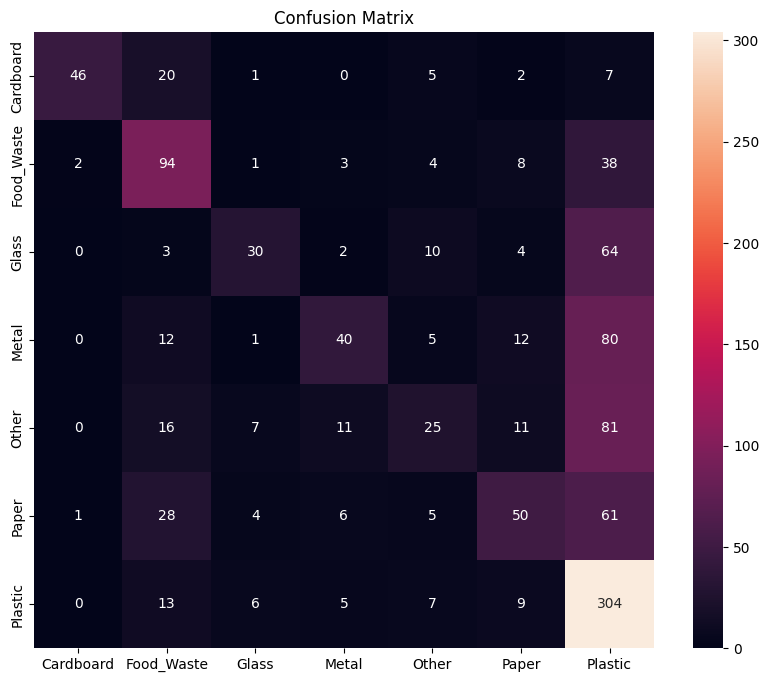

In [13]:
# Evaluate on the test set; display suitable metrics

# Evaluate the model
test_loss, test_acc = model.evaluate(X_val, y_val)
print(f"Test Accuracy: {test_acc:.4f}")

# Predictions
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

# Classification report
print(classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_))

# Confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_true, y_pred_classes),
            annot=True, fmt='d',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.show()

## **4. Data Augmentation** <font color=red> [optional] </font><br>

#### **4.1 Create a Data Augmentation Pipeline**

##### **4.1.1**
Define augmentation steps for the datasets.

In [14]:
# Create data augmentation pipeline
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# Fit the augmentation on training data
datagen.fit(X_train)

# Train model with augmented data
aug_history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                        epochs=30,
                        validation_data=(X_val, y_val),
                        callbacks=callbacks)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
167/167 ━━━━━━━━━━━━━━━━━━━━ 23s 105ms/step - accuracy: 0.3410 - loss: 1.7657 - val_accuracy: 0.3671 - val_loss: 1.5884
Epoch 2/30
167/167 ━━━━━━━━━━━━━━━━━━━━ 13s 80ms/step - accuracy: 0.3595 - loss: 1.6855 - val_accuracy: 0.4615 - val_loss: 1.4383
Epoch 3/30
167/167 ━━━━━━━━━━━━━━━━━━━━ 13s 80ms/step - accuracy: 0.3619 - loss: 1.6893 - val_accuracy: 0.4502 - val_loss: 1.4411
Epoch 4/30
167/167 ━━━━━━━━━━━━━━━━━━━━ 20s 79ms/step - accuracy: 0.3713 - loss: 1.6408 - val_accuracy: 0.4720 - val_loss: 1.4411
Epoch 5/30
167/167 ━━━━━━━━━━━━━━━━━━━━ 13s 79ms/step - accuracy: 0.3736 - loss: 1.6195 - val_accuracy: 0.4493 - val_loss: 1.4775
Epoch 6/30
167/167 ━━━━━━━━━━━━━━━━━━━━ 13s 77ms/step - accuracy: 0.3675 - loss: 1.6145 - val_accuracy: 0.4449 - val_loss: 1.5526
Epoch 7/30
167/167 ━━━━━━━━━━━━━━━━━━━━ 14s 83ms/step - accuracy: 0.3893 - loss: 1.5960 - val_accuracy: 0.4309 - val_loss: 1.4940


Augment and resample the images.
In case of class imbalance, you can also perform adequate undersampling on the majority class and augment those images to ensure consistency in the input datasets for both classes.

Augment the images.

In [ ]:
# Create the augmented training dataset



##### **4.1.2**

Train the model on the new augmented dataset.

In [ ]:
# Train the model using augmented images



## **5. Conclusions** <font color = red> [5 marks]</font>

#### **5.1 Conclude with outcomes and insights gained** <font color =red> [5 marks] </font>

* Report your findings about the data
  1. The dataset contains approximately 7,000 images across 7 categories (Cardboard, Food Waste, Glass, Metal, Paper, Plastic, Other).

  2. Initial visualization showed some class imbalance, which we handled through stratified splitting.

  3. Images had varying dimensions, so we standardized them to 128x128 pixels for model input.


* Report model training results
